In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('../data/transformed/final_dataframe.csv', index_col=0)

In [3]:
df[['home_team', 'visitor_team']] = df[['home_team', 'visitor_team']].astype('category')
df['home_team_cat'] = df['home_team'].cat.codes
df['visitor_team_cat'] = df['visitor_team'].cat.codes
df['home_final'] = df[[col for col in df.columns if 'H ' in col]].sum(axis=1)
df['visitor_final'] = df[[col for col in df.columns if 'V ' in col]].sum(axis=1)
scores = df[['home_final', 'visitor_final']].values.reshape(-1, 1)
score_scaler = StandardScaler().fit(scores)
scaled_scores = score_scaler.transform(scores).reshape(-1, 2)
df['home_final_scaled'] = scaled_scores[:, 0]
df['visitor_final_scaled'] = scaled_scores[:, 1]

In [4]:
df['final_spread'] = df['home_final'] - df['visitor_final']
df['final_total'] = df['home_final'] + df['visitor_final']
df['final_margin_from_open_spread'] = df['final_spread'] - (df['home_score_open'] - df['visitor_score_open'])
df['final_margin_from_open_total'] = df['final_total'] - (df['home_score_open'] + df['visitor_score_open'])

In [5]:
seq_len = 100
state_size = 6
teams = len(df['visitor_team'].cat.categories)
line_used = 'open'

In [6]:
def map_to_cat(x, categories):
    if x == categories[0]:
        return 1
    elif x == categories[1]:
        return 0
    else:
        return 0.5

In [7]:
df['open_spread_win_cat'] = df['open_spread_win'].apply(
    lambda x: map_to_cat(x, categories=['home', 'visitor', 'push']))
df['close_spread_win_cat'] = df['close_spread_win'].apply(
    lambda x: map_to_cat(x, categories=['home', 'visitor', 'push']))
df['open_total_win_cat'] = df['open_total_win'].apply(
    lambda x: map_to_cat(x, categories=['over', 'under', 'push']))
df['close_total_win_cat'] = df['close_total_win'].apply(
    lambda x: map_to_cat(x, categories=['over', 'under', 'push']))

In [8]:
train = range(27, 6827)
test = range(6827, len(df)-1)

seq_start = [train[0] + len(train)%seq_len + seq_len*i for i in range(len(train)//seq_len)]
time_series_train = [range(start, start+seq_len) for start in seq_start]
time_series_plus_train = [range(start+1, start+1+seq_len) for start in seq_start]
seq_start_test = [test[0] + seq_len*i for i in range(len(test)//seq_len)]
time_series_test = [range(start, start+seq_len) for start in seq_start_test]
time_series_plus_test = [range(start+1, start+1+seq_len) for start in seq_start_test]

In [9]:
def convert_to_time_series(tensor, time_series_list):
    tensor_list = []
    for r in time_series_list:
        tensor_list += [tensor[r]]
    return np.stack(tensor_list)

In [10]:
cols = ['home_team_cat', 'visitor_team_cat']
teams_train = convert_to_time_series(
    df[cols].values, time_series_train).astype(np.int32)
teams_plus_train = convert_to_time_series(
    df[cols].values, time_series_plus_train).astype(np.int32)
teams_test = convert_to_time_series(
    df[cols].values, time_series_test).astype(np.int32)
teams_plus_test = convert_to_time_series(
    df[cols].values, time_series_plus_test).astype(np.int32)

In [11]:
cols = ['home_days_since_home', 'home_days_since_away', 'visitor_days_since_home', 'visitor_days_since_away']
days_scaled = StandardScaler().fit_transform(df[cols])
scaled_cols = []
for i, col in enumerate(cols):
    scaled_cols += [col+'_scaled']
    df[col+'_scaled'] = days_scaled[:, i]

days_off_train = convert_to_time_series(
    df[scaled_cols].values, time_series_train)
days_off_plus_train = convert_to_time_series(
    df[scaled_cols].values, time_series_plus_train)
days_off_test = convert_to_time_series(
    df[scaled_cols].values, time_series_test)
days_off_plus_test = convert_to_time_series(
    df[scaled_cols].values, time_series_plus_test)

In [12]:
cols = ['home_score_open', 'visitor_score_open', 'home_score_close', 'visitor_score_close']
lines_scaler = StandardScaler().fit(df[cols])
lines_scaled = lines_scaler.transform(df[cols])
scaled_cols = []
for i, col in enumerate(cols):
    scaled_cols += [col+'_scaled']
    df[col+'_scaled'] = lines_scaled[:, i]

lines_train = convert_to_time_series(
    df[scaled_cols].values, time_series_train)
lines_test = convert_to_time_series(
    df[scaled_cols].values, time_series_test)

cols = [col for col in scaled_cols if line_used in col]
lines_plus_train = convert_to_time_series(
    df[cols].values, time_series_plus_train)
lines_plus_test = convert_to_time_series(
    df[cols].values, time_series_plus_test)

In [13]:
cols = ['H 1st', 'H 2nd', 'H 3rd', 'H 4th', 'V 1st', 'V 2nd', 'V 3rd', 'V 4th']
scores_scaled = StandardScaler().fit_transform(df[cols])
scaled_cols = []
for i, col in enumerate(cols):
    scaled_cols += [col+'_scaled']
    df[col+'_scaled'] = scores_scaled[:, i]

scores_train = convert_to_time_series(
    df[scaled_cols].values, time_series_train)
scores_test = convert_to_time_series(
    df[scaled_cols].values, time_series_test)

cols = ['home_final_scaled', 'visitor_final_scaled']
scores_plus_train = convert_to_time_series(
    df[cols].values, time_series_plus_train)
scores_plus_test = convert_to_time_series(
    df[cols].values, time_series_plus_test)

cols = ['open_spread_win_cat', 'open_total_win_cat', 'close_spread_win_cat', 'close_total_win_cat']
cols = [col for col in cols if line_used in col]
outcomes_plus_train = convert_to_time_series(
    df[cols].values, time_series_plus_train) / 2 + 0.25
outcomes_plus_test = convert_to_time_series(
    df[cols].values, time_series_plus_test) / 2 + 0.25

In [14]:
model = build_model(seq_len, state_size, teams)

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


In [15]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(1, 100, 4)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(1, 100, 4)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(1, 100, 8)]        0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(1, 100, 4)]        0                                            
_______________________________________________________________________________________

In [18]:
import copy

def shuffle_games(X, distance=10, fraction=0.25):
    reorder = np.random.choice(X[0].shape[1] - distance, 
                               size=(int(X[0].shape[1] * fraction)),
                               replace=False)
    targets = reorder + distance
    keep = np.array([k for k, r in enumerate(reorder) if r not in targets])
    reorder = reorder[keep]
    targets = targets[keep]

    X_out = []
    for tensor in X:
        tensor[:, np.append(targets, reorder)] = tensor[:, np.append(reorder, targets)]
        X_out += [tensor]
    
    return X_out

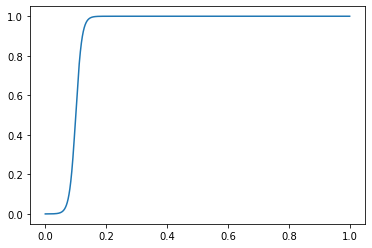

In [53]:
def sigmoid(x):
    return 1/(1+np.exp(-(x-0.1)/0.01))

x = np.linspace(0, 1, len(train))
sample_weights = np.expand_dims(sigmoid(x),axis=1)

sample_weights_final = [sample_weights.reshape(68, 100), sample_weights.reshape(68, 100)]

plt.plot(x, sample_weights)
plt.show()

In [57]:
opt = tf.keras.optimizers.Adam(lr=0.001)
negloglik = lambda y, p_y: -p_y.log_prob(y)
model.compile(
    optimizer=opt, loss=negloglik
)
epochs = 2

In [59]:
X = [np.expand_dims(teams_train, axis=-1), days_off_train, lines_train, scores_train, 
     np.expand_dims(teams_plus_train, axis=-1), days_off_plus_train, lines_plus_train, scores_plus_train]

for i in range(epochs):
    print('Epoch {}'.format(str(i+1)))
    model.reset_states()
    #X = shuffle_games(copy.deepcopy(X))
    model.fit(
        x=X[:7],
        y=X[7:],
        batch_size=1,
        epochs=1,
        sample_weight=sample_weights_final,
        verbose=1
    )

Epoch 1
68/68 [==============================] - 2s 27ms/step - loss: 2.2495
Epoch 2
68/68 [==============================] - 2s 27ms/step - loss: 2.2236


In [60]:
rnn_layer = model.layers[8]

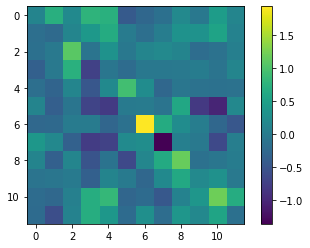

In [61]:
plt.imshow(rnn_layer.get_weights()[3])
plt.colorbar()

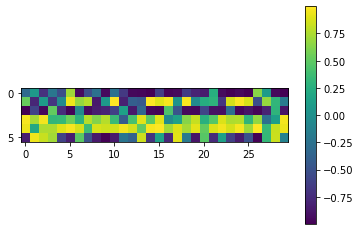

In [62]:
plt.imshow(rnn_layer.states[0][0].numpy().T)
plt.colorbar()

In [63]:
df_states = pd.DataFrame(rnn_layer.states[0][0].numpy().T, columns=list(df['home_team'].cat.categories))

<AxesSubplot:>

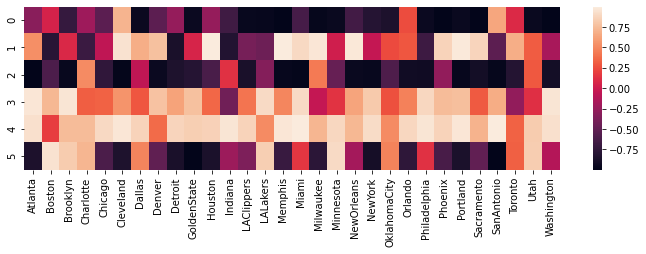

In [64]:
plt.rcParams['figure.figsize'] = 12, 3
sn.heatmap(df_states)

In [65]:
import copy
states = copy.deepcopy(rnn_layer.states)

In [66]:
rnn_layer.reset_states(states[0].numpy())

In [67]:
result = ResultsProcessor(score_scaler, min_score=60, max_score=160)

In [68]:
if line_used == 'open':
    cols = np.array([0, 1])
else:
    cols = np.array([2, 3])

In [69]:
mvns = []
spread_preds = np.array([])
total_preds = np.array([])
for batch in range(teams_test.shape[0]):
    score_preds_ = model(
        [np.expand_dims(teams_test, axis=-1)[batch: batch+1], 
            days_off_test[batch: batch+1], 
            lines_test[batch: batch+1], scores_test[batch: batch+1], 
            np.expand_dims(teams_plus_test, axis=-1)[batch: batch+1], 
            days_off_plus_test[batch: batch+1], lines_plus_test[batch: batch+1]])
    print(rnn_layer.states[0].numpy()[0, 10])
    mvns += result.make_mvn_from_batch(score_preds_)
    lines = lines_plus_test[batch] * lines_scaler.scale_[cols] + lines_scaler.mean_[cols]
    spreads = lines[:, 0] - lines[:, 1]
    totals = lines[:, 0] + lines[:, 1]
    spread_like, total_like = result.get_spread_total_likelihood(
        mvns, spreads, totals)
    spread_preds = np.append(spread_preds, spread_like)
    total_preds = np.append(total_preds, total_like)

[-0.9956843   0.264063    0.02881694  0.8177469   0.9295539  -0.9624172 ]
[-0.24910232 -0.6307404  -0.61029476  0.79717606  0.7969672   0.45109707]
[ 0.8916205  -0.13324583 -0.86721754  0.8651361   0.9453449  -0.6182403 ]
[ 0.2767078  -0.7555462  -0.92183065  0.71547264  0.98727655 -0.978232  ]
[-0.46193206 -0.38054043 -0.47482938  0.7067473   0.5788447   0.97401106]


In [72]:
mvns_train = []
spread_preds_train = np.array([])
total_preds_train = np.array([])
rnn_layer.reset_states(np.zeros(states[0].numpy().shape))
for batch in range(teams_train.shape[0]):
    score_preds_ = model(
        [np.expand_dims(teams_train, axis=-1)[batch: batch+1], 
            days_off_train[batch: batch+1], 
            lines_train[batch: batch+1], scores_train[batch: batch+1], 
            np.expand_dims(teams_plus_train, axis=-1)[batch: batch+1], 
            days_off_plus_train[batch: batch+1], lines_plus_train[batch: batch+1]])
    print(rnn_layer.states[0].numpy()[0, 10])
    mvns_train += result.make_mvn_from_batch(score_preds_)
    lines = lines_plus_train[batch] * lines_scaler.scale_[cols] + lines_scaler.mean_[cols]
    spreads = lines[:, 0] - lines[:, 1]
    totals = lines[:, 0] + lines[:, 1]
    spread_like, total_like = result.get_spread_total_likelihood(
        mvns_train, spreads, totals)
    spread_preds_train = np.append(spread_preds_train, spread_like)
    total_preds_train = np.append(total_preds_train, total_like)

[ 0.00260568 -0.6071252  -0.8770363   0.80746806  0.35232332 -0.75832254]
[-0.16335559 -0.58751583 -0.13137046 -0.18151982  0.9699148  -0.96863997]
[-0.5112295  -0.72401106  0.45676938  0.2530309  -0.14593326  0.8275408 ]
[-0.06231043  0.68689334 -0.85883695  0.7811768   0.9352322   0.6829551 ]
[-0.94422746 -0.12072736 -0.9652581   0.644179    0.9148917  -0.00789759]
[-0.8938017  -0.8750427  -0.61240125  0.11374605  0.65883076  0.70419526]
[-0.5047245  -0.82906795 -0.8750412   0.5516952   0.6584879  -0.62994814]
[ 0.1454542  -0.75203073 -0.90931296  0.47877097 -0.15677983 -0.93290967]
[ 0.056662    0.09269518 -0.6516191   0.52220786  0.8806943  -0.6558492 ]
[-0.57456553 -0.21719265 -0.8953341   0.21428046  0.89616835 -0.9107058 ]
[ 0.60651714  0.87547827 -0.6192801  -0.09227633  0.6631396  -0.46345216]
[-0.96362495  0.11702341  0.9328299  -0.18814169  0.65306073  0.7501755 ]
[-0.20423537 -0.9870096  -0.3346365   0.62863606  0.22417177  0.5961893 ]
[-0.86788255  0.63651377 -0.8423174   

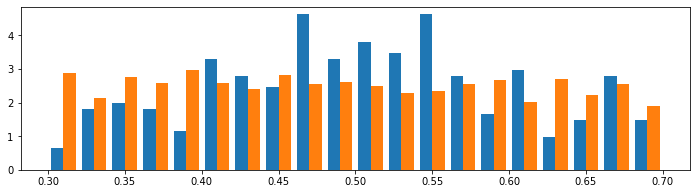

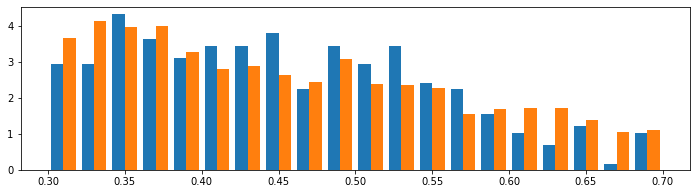

In [73]:
bins = np.linspace(0.3, 0.7, 21)
plt.hist([spread_preds, spread_preds_train], density=True, bins=bins)
plt.show()

plt.hist([total_preds, total_preds_train], density=True, bins=bins)
plt.show()

In [74]:
means = []
for mvn in mvns:
    means += [mvn.mean]

score_preds = score_scaler.inverse_transform(
    np.array(means).reshape(-1, 1)).reshape(-1, 2)

means = []
for mvn in mvns_train:
    means += [mvn.mean]

score_preds_train = score_scaler.inverse_transform(
    np.array(means).reshape(-1, 1)).reshape(-1, 2)

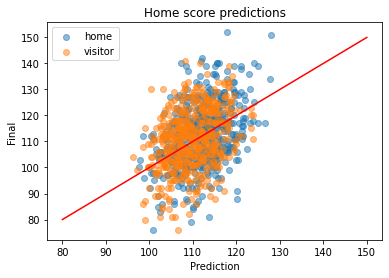

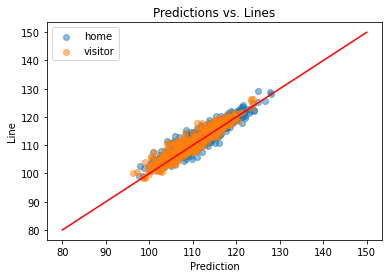

In [75]:
plt.rcParams['figure.figsize'] = 6, 4

plt.scatter(score_preds[:, 0], df['home_final'][-500:], alpha=0.5, label='home')
plt.scatter(score_preds[:, 1], df['visitor_final'][-500:], alpha=0.5, label='visitor')
plt.plot([80, 150], [80, 150], 'red')
plt.legend()
plt.xlabel('Prediction')
plt.ylabel('Final')
plt.title('Home score predictions')
plt.show()

plt.scatter(score_preds[:, 0], df['home_score_open'][-500:], alpha=0.5, label='home')
plt.scatter(score_preds[:, 1], df['visitor_score_open'][-500:], alpha=0.5, label='visitor')
plt.plot([80, 150], [80, 150], 'red')
plt.legend()
plt.xlabel('Prediction')
plt.ylabel('Line')
plt.title('Predictions vs. Lines')
plt.show()


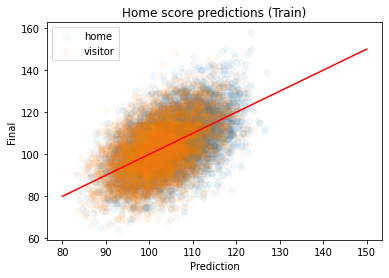

In [76]:
plt.scatter(score_preds_train[:, 0], df['home_final'][28:-500], alpha=0.05, label='home')
plt.scatter(score_preds_train[:, 1], df['visitor_final'][28:-500], alpha=0.05, label='visitor')
plt.plot([80, 150], [80, 150], 'red')
plt.legend()
plt.xlabel('Prediction')
plt.ylabel('Final')
plt.title('Home score predictions (Train)')
plt.show()

In [77]:
home_error = mean_absolute_error(df['home_final'][-500:], score_preds[:, 0])
visitor_error = mean_absolute_error(df['visitor_final'][-500:], score_preds[:, 1])
home_line_error = mean_absolute_error(df['home_final'][-500:], df['home_score_open'][-500:])
visitor_line_error = mean_absolute_error(df['visitor_final'][-500:], df['visitor_score_open'][-500:])
print(home_error)
print(visitor_error)
print(home_line_error)
print(visitor_line_error)

8.853422511092333
8.755146489136205
8.7715
8.5875


In [78]:
home_error_train = mean_absolute_error(df['home_final'][28:-500], score_preds_train[:, 0])
visitor_error_train = mean_absolute_error(df['visitor_final'][28:-500], score_preds_train[:, 1])
home_line_error_train = mean_absolute_error(df['home_final'][28:-500], df['home_score_open'][28:-500])
visitor_line_error_train = mean_absolute_error(df['visitor_final'][28:-500:], df['visitor_score_open'][28:-500])
print(home_error_train)
print(visitor_error_train)
print(home_line_error_train)
print(visitor_line_error_train)

8.325691126655475
8.358217307331671
8.300182977941176
8.333125845588235


In [79]:
print(np.corrcoef(spread_preds, df['final_margin_from_open_spread'][-500:])[0, 1])
print(np.corrcoef(spread_preds, np.sign(df['final_margin_from_open_spread'][-500:]))[0, 1])
print(np.corrcoef(total_preds, df['final_margin_from_open_total'][-500:])[0, 1])
print(np.corrcoef(total_preds, np.sign(df['final_margin_from_open_total'][-500:]))[0, 1])

0.01312682837251369
-0.02297900304588441
0.04782157458127832
0.03038946655333913


In [80]:
print(np.corrcoef(spread_preds_train, df['final_margin_from_open_spread'][28:-500])[0, 1])
print(np.corrcoef(spread_preds_train, np.sign(df['final_margin_from_open_spread'][28:-500]))[0, 1])
print(np.corrcoef(total_preds_train, df['final_margin_from_open_total'][28:-500])[0, 1])
print(np.corrcoef(total_preds_train, np.sign(df['final_margin_from_open_total'][28:-500]))[0, 1])

0.022713813058067224
0.017543907454524055
0.026924235494263978
0.025151627424473615


In [81]:
spread_model = LinearRegression()
total_model = LinearRegression()
spread_model.fit(spread_preds.reshape(-1, 1), df['final_margin_from_open_spread'][-500:])
total_model.fit(total_preds.reshape(-1, 1), df['final_margin_from_open_total'][-500:])

LinearRegression()

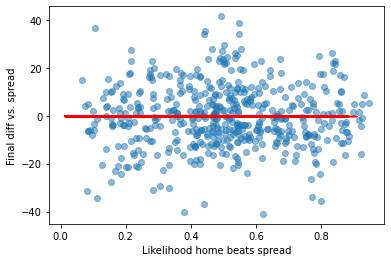

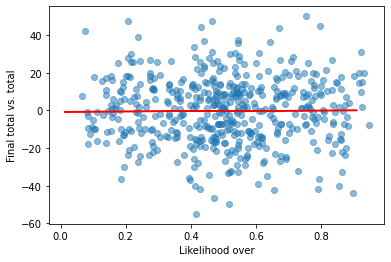

In [82]:
plt.scatter(spread_preds, df['final_margin_from_open_spread'][-500:], alpha=0.5)
plt.plot(total_preds, spread_model.predict(spread_preds.reshape(-1, 1)), c='red')
plt.xlabel('Likelihood home beats spread')
plt.ylabel('Final diff vs. spread')
plt.show()

plt.scatter(spread_preds, df['final_margin_from_open_total'][-500:], alpha=0.5)
plt.plot(total_preds, spread_model.predict(total_preds.reshape(-1, 1)), c='red')
plt.xlabel('Likelihood over')
plt.ylabel('Final total vs. total')
plt.show()

In [83]:
spread_wins = len(np.where((spread_preds > 0.5) & (df['final_margin_from_open_spread'][-500:] > 0))[0])
spread_wins += len(np.where((spread_preds < 0.5) & (df['final_margin_from_open_spread'][-500:] < 0))[0])
den = 500 - len(np.where(df['final_margin_from_open_spread'][-500:] == 0)[0])
win_fraction = spread_wins / den
win_fraction

0.4847870182555781

In [84]:
total_wins = len(np.where((total_preds > 0.5) & (df['final_margin_from_open_total'][-500:] > 0))[0])
total_wins += len(np.where((total_preds < 0.5) & (df['final_margin_from_open_total'][-500:] < 0))[0])
den = 500 - len(np.where(df['final_margin_from_open_total'][-500:] == 0)[0])
win_fraction = total_wins / den
win_fraction

0.5100401606425703

In [85]:
spread_wins_train = len(np.where((spread_preds_train > 0.5) & (df['final_margin_from_open_spread'][28:-500] > 0))[0])
spread_wins_train += len(np.where((spread_preds_train < 0.5) & (df['final_margin_from_open_spread'][28:-500] < 0))[0])
den = 6800 - len(np.where(df['final_margin_from_open_spread'][28:-500] == 0)[0])
win_fraction = spread_wins_train / den
win_fraction

0.5103541416566627

In [86]:
total_wins_train = len(np.where((total_preds_train > 0.5) & (df['final_margin_from_open_total'][28:-500] > 0))[0])
total_wins_train += len(np.where((total_preds_train < 0.5) & (df['final_margin_from_open_total'][28:-500] < 0))[0])
den = 6800 - len(np.where(df['final_margin_from_open_spread'][28:-500] == 0)[0])
win_fraction = total_wins_train / den
win_fraction

0.5361644657863145